=== CPU Anomaly Detection ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2737
           1       0.96      0.94      0.95       263

    accuracy                           0.99      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.99      0.99      0.99      3000

Optimal Threshold: 0.84
F1-Score: 0.950


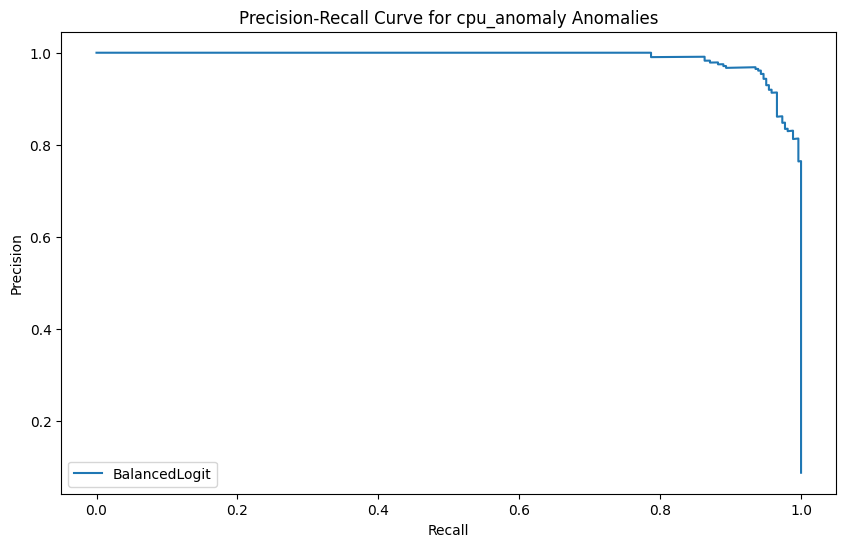


=== Memory Anomaly Detection ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2926
           1       0.96      0.69      0.80        74

    accuracy                           0.99      3000
   macro avg       0.98      0.84      0.90      3000
weighted avg       0.99      0.99      0.99      3000

Optimal Threshold: 0.94
F1-Score: 0.803


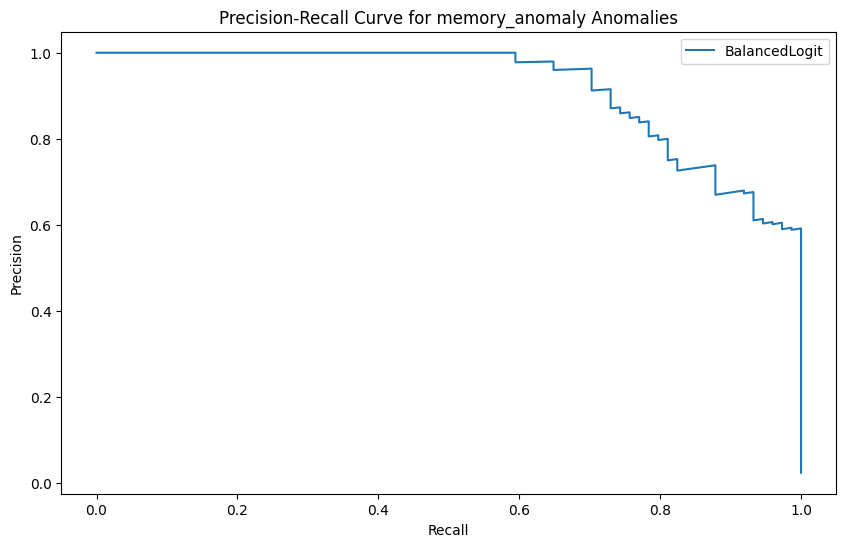

In [1]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# --- Load Data & Feature Engineering ---
df = pd.read_csv("kubernetes_resource_allocation_dataset.csv")

# Add derived features for both CPU and memory
df['cpu_utilization'] = df['cpu_usage'] / df['cpu_limit']
df['memory_utilization'] = df['memory_usage'] / df['memory_limit']
df['cpu_request_diff'] = df['cpu_usage'] - df['cpu_request']
df['memory_request_diff'] = df['memory_usage'] - df['memory_request']

features = [
    'cpu_usage', 'memory_usage', 'cpu_utilization', 'memory_utilization',
    'cpu_request_diff', 'memory_request_diff', 'restart_count', 
    'cpu_limit', 'memory_limit'
]

# --- Add Real-World Noise ---
np.random.seed(42)
noise_factor = 0.1
for col in ['cpu_usage', 'memory_usage']:
    df[col] = df[col] * (1 + noise_factor * np.random.randn(len(df)))

# --- Time-Based Processing ---
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Rolling features for both resources
window_size = 7
for df_split in [train_df, test_df]:
    # CPU features
    df_split['cpu_ma'] = df_split['cpu_usage'].rolling(window_size).mean()
    df_split['cpu_std'] = df_split['cpu_usage'].rolling(window_size).std()
    
    # Memory features
    df_split['memory_ma'] = df_split['memory_usage'].rolling(window_size).mean()
    df_split['memory_std'] = df_split['memory_usage'].rolling(window_size).std()

# Use last training window stats for test data
test_df['cpu_ma'] = train_df['cpu_ma'].iloc[-window_size:].mean()
test_df['cpu_std'] = train_df['cpu_std'].iloc[-window_size:].mean()
test_df['memory_ma'] = train_df['memory_ma'].iloc[-window_size:].mean()
test_df['memory_std'] = train_df['memory_std'].iloc[-window_size:].mean()

# Anomaly detection logic for both resources
train_df['cpu_anomaly'] = (train_df['cpu_usage'] > (train_df['cpu_ma'] + 1.5 * train_df['cpu_std'])).astype(int)
train_df['memory_anomaly'] = (train_df['memory_usage'] > (train_df['memory_ma'] + 1.5 * train_df['memory_std'])).astype(int)

test_df['cpu_anomaly'] = (test_df['cpu_usage'] > (test_df['cpu_ma'] + 1.5 * test_df['cpu_std'])).astype(int)
test_df['memory_anomaly'] = (test_df['memory_usage'] > (test_df['memory_ma'] + 1.5 * test_df['memory_std'])).astype(int)

# --- Data Preparation ---
train_df = train_df.dropna()
test_df = test_df.dropna()

# --- Model Training Function ---
def train_and_evaluate(target):
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[target]
    y_test = test_df[target]

    # Feature Scaling & Resampling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Train and evaluate model
    model = LogisticRegression(
        class_weight='balanced',
        solver='saga',
        max_iter=1000
    )
    model.fit(X_resampled, y_resampled)
    probs = model.predict_proba(X_test_scaled)[:, 1]
    
    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Store results
    results = {
        'report': classification_report(y_test, (probs > best_threshold).astype(int)),
        'f1': f1_score(y_test, (probs > best_threshold).astype(int)),
        'threshold': best_threshold,
        'probs': probs
    }
    
    return results

# --- Visualization ---
def plot_pr_curves(results, target_name):
    plt.figure(figsize=(10, 6))
    probs = results['probs']
    precision, recall, _ = precision_recall_curve(test_df[target_name], probs)
    plt.plot(recall, precision, label='BalancedLogit')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {target_name} Anomalies')
    plt.legend()
    plt.show()

# --- Train and Evaluate ---
print("=== CPU Anomaly Detection ===")
cpu_results = train_and_evaluate('cpu_anomaly')
print(cpu_results['report'])
print(f"Optimal Threshold: {cpu_results['threshold']:.2f}")
print(f"F1-Score: {cpu_results['f1']:.3f}")
plot_pr_curves(cpu_results, 'cpu_anomaly')

print("\n=== Memory Anomaly Detection ===")
memory_results = train_and_evaluate('memory_anomaly')
print(memory_results['report'])
print(f"Optimal Threshold: {memory_results['threshold']:.2f}")
print(f"F1-Score: {memory_results['f1']:.3f}")
plot_pr_curves(memory_results, 'memory_anomaly')
